**Data discovery using FITS (FIeld Time Series) database - for data types / collection methods**

In this notebook we will look at discovering which sites have data of a given type / collection method in the FITS (FIeld Time Series) database. Again some functionality from previous notebooks will be imported as functions. To begin, run the following segment:

In [1]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define functions

def build_query(typeID, typeIDtype, typeinfo = False):
    
    '''
    Take data / method type and generate a FITS API query for an JSON file.
    Valid typeIDtypes are 'methodID' and 'typeID'
    typeinfo is boolen, and set to False by default
    '''
    
    # Build queries
        
    query_suffix = ''
    
    query_suffix = typeIDtype + '=' + typeID # Combine parameter=value pairs into query format
        
    # If chosen, print out information about data type and/or data collection method
        
    if typeinfo == True:
            
        supplement_query(typeID, typeIDtype)

    # Combine the query parameter=value string with the FITS observation data URL

    URL = 'https://fits.geonet.org.nz/site?' + query_suffix

    return URL

We have now defined a function for building FITS queries. However, we have made room for a supplementary function within this: the supplement_query function. We will now build this function, which will provide information about the data type and data collection methods we use to build our query.

In the FITS database data type and collection method information are stored in [JSON](https://www.json.org/) format. When we query this information in the supplement_query function, we will use pandas to parse JSON format into python.

In [2]:
def supplement_query(typeID, typeIDtype):
    
    '''
    Look up information for the data/method type with typeID
    Valid typeIDtypes are 'methodID' and 'typeID'
    '''
    
    # Ensure typeIDtype is of the correct format
    
    typeIDtype = typeIDtype[:typeIDtype.index('ID')]
    
    # Build query prefix
    
    URL = 'https://fits.geonet.org.nz/' + typeIDtype
    
    # Get all data type / collection method information in JSON format
    
    try:
    
        data = pd.read_json(URL).iloc[:,0] # Only load first column
        
    except:
        
        print('Not a valid typeIDtype')
        
        return
    
    # Locate the dictionary containing information for the data/method type in the JSON file
    
    match = False
    
    for type_details in data:
        
        if typeID == type_details[typeIDtype + 'ID']:
            
            match = True
            
            # Print out the data type information
            
            for type_detail in type_details:
                                        
                print(type_detail + ' : ' + type_details[type_detail])
             
            print('\n')
            
            # Optional: leave this uncommented to only allow the first
            # apperance of a method in the JSON file to be printed
            
            break
        
    if not match:
        
        print('Not a valid typeID')

Now we need to set our query parameters and run our function(s).

We can use the build_query function to create a list of sites with data for one or more of the data types / collection methods we set, and we can get information about these data types / collection methods with our supplement_query function. By using the [set](https://docs.python.org/3/tutorial/datastructures.html#sets) type in Python, we can also get the list of sites with **all** data types / collection methods. In the next section, we will do all these things.

In [3]:
# Set data/method types of interest

typeID = ['SO2-flux-a', 'CO2-flux-a'] # ID are the data types or data collection methods of interest
typeIDtype = ['typeID', 'typeID',] # typeIDtype tells the code if the corresponding typeID is for a data type or method

# Ensure parameters are in the correct format for use with this function
    
if type(typeID) != list:

    temp_typeID = typeID
    typeID = []
    typeID.append(temp_typeID)

if type(typeIDtype) != list:

    temp_typeIDtype = typeIDtype
    typeIDtype = []
    typeIDtype.append(temp_typeIDtype)
    
# Warn the operator if each ID does not have a corresponding typeIDtype
    
if len(typeID) != len(typeIDtype):
    
    print('Number of sites and corresponding data types are not equal!')

    
# Build list of sites for each data type

data = [[] for i in range(len(typeID))]
for i in range(len(typeID)):

    # Build the FITS API query

    URL = build_query(typeID[i], typeIDtype[i], typeinfo = True)
    
    # Pull the site list that the query returns

    data[i] = pd.read_json(URL).iloc[:,0].values # Only load first column

    
# Gather site codes from the data lists

all_sites = [[] for i in range(len(data))] # Prepare site code list
for i in range(len(data)):
    for site_dictionaries in data[i]:

        all_sites[i].append(site_dictionaries['properties']['siteID'])

    all_sites[i] = set(all_sites[i])
    
    
# Return site lists to the operator

for i in range(len(typeID)):
    print('Sites with data of ' + typeIDtype[i] + ' ' + typeID[i] + ':\n')
    for site in all_sites[i]:   
        print(site)
    print('\n')
    
    
# Find the sites that have all data types specified
# (use an intersection of many sets)

if len(all_sites) > 1:
    
    for i in range(1, len(data)):
    
        sites = all_sites[i - 1].intersection(all_sites[i])
    
    sites = list(sites)    
    
else:
    
    sites = list(all_sites[0])

    
# Return information to the operator
    
outstr = 'Sites with data of '
for i in range(len(typeID)):
    outstr += typeIDtype[i] + ' ' + typeID[i] + ', '
outstr = outstr[:-2] + ' are:\n'

print(outstr)
    
if len(sites) > 0:
    sites.sort()
    for site in sites:
        print(site)
else:
    print('No site exists with data of all types / collection methods specified.')

typeID : SO2-flux-a
name : Sulphur Dioxide flux in air
unit : kg/s
description : flux of sulphur dioxide measured in the air


typeID : CO2-flux-a
name : Carbon Dioxide flux in air
unit : kg/s
description : flux of carbon dioxide measured in the air


Sites with data of typeID SO2-flux-a:

NA000
TO301
WI302
TO000
WI000
TO312
WI301
TO302
TO311
RU000


Sites with data of typeID CO2-flux-a:

TO000
WI000
RU000
NA000


Sites with data of typeID SO2-flux-a, typeID CO2-flux-a are:

NA000
RU000
TO000
WI000


By using some more of the code from previous notebooks we can take the *sites* variable, AKA the list of all site codes with data for **all** the data types / collection methods, and use it to plot huge swaths of data all at once. However, before doing this we'll need to set a few more parameters to avoid crashing the host computer.

In [4]:
# Define plotting times

start_year = '2017' # four digit year
start_month = '07' # two digit month
start_day = '01' # two digit day

end_year = '2017'
end_month = '11'
end_day = '01'

# Convert bounding times to datetime objects

import datetime

start_date = datetime.datetime.strptime(start_year + '-' + start_month + '-' + start_day, '%Y-%m-%d')
end_date = datetime.datetime.strptime(end_year + '-' + end_month + '-' + end_day, '%Y-%m-%d')

However, if you want to plot all data, run the code segment below:

In [5]:
# Alternatively, gather all data

start_date = pd.Timestamp.min
end_date = pd.Timestamp.max

Now we need to gather data for the sites in *sites* for the data type(s) / collection method(s) specified. To do this we will build a new function:

In [6]:
def get_obs(sites, data_type, start_date, end_date):
    
    '''
    Take site code and data type, generate a FITS API query for an observations csv file,
    and parse that file into python using pandas.
    start_date and end_date are datetime objects.
    '''

    # Create a list to store DataFrame objects in

    data = [[] for j in range(len(sites))]
    
    # Create list to store names of sites with data over the specified period
    
    sites_with_data = [] 

    # Parse csv data from the FITS database into the data list 

    for j in range(len(sites)):
        
        # Ensure site is in python string format
        
        site = str(sites[j])
    
        # Build a FITS API query by combining parameter:value pairs in the query format

        query_suffix = 'siteID=%s&typeID=%s' % (site, data_type)

        # Combine the query parameter=value string with the FITS observation data URL

        URL = 'https://fits.geonet.org.nz/observation?' + query_suffix
    
        try:
    
            data[j] = pd.read_csv(URL, names=['date-time', data_type, 'error'], header=0, parse_dates = [0], index_col = 0)
        
            # Do not load empty DataFrames

            if (len(data[j].values) < 1):
                
                continue
                                
            else:
            
                sites_with_data.append(sites[j])
        
            # Subset this data to the window specified by start_date and end_date
        
            data[j] = data[j].loc[start_date:end_date,:]
        
        except:
            
            print('No observation data exists for ' + URL)
        
    return data, sites_with_data

We can now use the get_obs function with our *sites* list, *typeID* list, and *typeIDtype* list to collect data. To do this we will define a 2-dimensional list that will contain DataFrame objects. The 1st dimension of the list will be sorted by data type, and the 2nd dimension will contain DataFrame objects for each site for the given data type. In effect this will be a > 2-dimensional list, as each DataFrame object is 2-dimensional. 

In [7]:
# Generate data array

data_array = [[] for i in range(len(typeID))]

# Prepare sites with data list

sites_with_data = []

# Collect data and parse into data array

for i in range(len(typeID)):
    
    data, partial_sites_with_data = get_obs(sites, typeID[i], start_date, end_date)
    
    data_array[i] = data
    
    sites_with_data.extend(partial_sites_with_data)
    
# Remove repetition in site list

sites_with_data = list(set(sites_with_data))
sites_with_data.sort()

# Return information to the operator
    
outstr = 'Sites with data of '
for i in range(len(typeID)):
    outstr += typeIDtype[i] + ' ' + typeID[i] + ', '
outstr = outstr[:-2] + ' are:\n'

print(outstr)
    
if len(sites_with_data) > 0:
    sites.sort()
    for site in sites_with_data:
        print(site)
else:
    print('No site exists with data of all types / collection methods specified over the given time window.')

Sites with data of typeID SO2-flux-a, typeID CO2-flux-a are:

NA000
RU000
TO000
WI000


The site list output above may differ from the initial site list. Here we have removed all sites that do not have data over the time period we specified.

We will now plot all of the data we just gathered onto a single figure (or attempt to!). Here data types will be separated by subplot, and data from sites will be overlain within each subplot.

Keep in mind that if your original query returned a lot of sites, the following plots may be fairly crowded. Similarly, if a lot of data types were specified the same crowding may occur. To reduce crowding on the plot(s), change the *plot_sites* variable in the next code segment to a list of specific sites to plot.

In the next code segment another site list variable is defined. This variable is designed to contain only sites that have *values* in their DataFrames. Here the distinction between *data* and *values* is important: *data* in this case means that a DataFrame is not empty, i.e. it could contain headers or indexes, while *values* are actual observations. Some sites in the FITS database will appear to have data due to the existence of headers, but in reality no observations exists for these headers. This is an artefact of FITS, and tidying up this aspect of the database is an ongoing project at GeoNet.

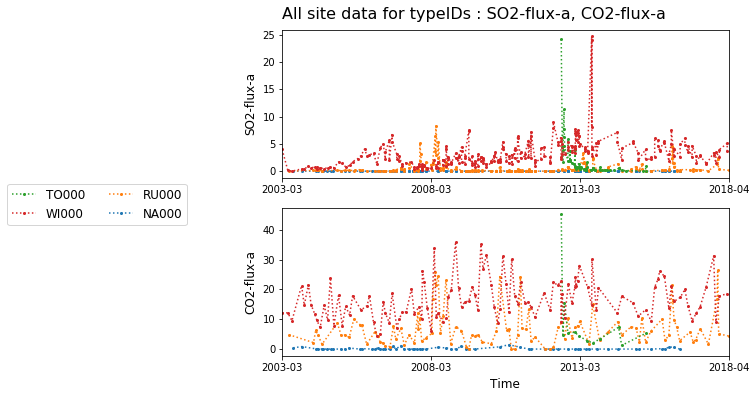

In [8]:
# Specify up to 9 sites to plot

plot_sites = sites_with_data

# Prepare another sites_with_data variable

sites_with_values = []

# Determine number and arrangement of subplots (max 9)

subplot_number = len(typeID)

if subplot_number / 3 > 1: # if there are more than 3 subplots
    
    rows = '3'
    
    if subplot_number / 6 > 1: # if there are more than 6 subplots
        
        cols = '3'
        
    else:
        
        cols = '2'
        
else:
    
    rows = str(subplot_number)
    cols = '1'  
    
ax = [[] for i in range(len(typeID))]
plots, labels = [[], []]

# Plot data

plt.figure(figsize = (8,6))

for i in range(len(typeID)): # i is data type index
    
    ax[i] = plt.subplot(int(rows + cols + str(i + 1)))
        
    for j in range(len(plot_sites)): # j is site index
        
        k = sites_with_data.index(plot_sites[j])  # match site chosen to position in data list
        
        if ((i == 0) and (j == 0)):
            
            # Set initial min/max times

            minmintime = min(data_array[i][k].index.values)
            maxmaxtime = max(data_array[i][k].index.values)
            
        # Do not plot empty DataFrames (and avoid cluttering the figure legend)
        
        if len(data_array[i][k].values) < 1:
            
            continue
            
        else:
            
            sites_with_values.append(plot_sites[j])

        try:

            ax[i].plot(data_array[i][k].loc[:, typeID[i]], label = plot_sites[j],
                      marker='o', linestyle=':', markersize = 2)
            
        except:
            
            continue
    
        # Get min, max times of dataset

        mintime = min(data_array[i][k].index.values)
        maxtime = max(data_array[i][k].index.values)

        # Set y label

        ax[i].set_ylabel(typeID[i], rotation = 90, labelpad = 5, fontsize = 12)

        # Gather legend details

        plot, label = ax[i].get_legend_handles_labels() 
        
        if i == (len(typeID) - 1):
            
            plots.extend(plot)
            labels.extend(label)

        # Get min, max times of all data

        minmintime = min(mintime, minmintime)
        maxmaxtime = max(maxtime, maxmaxtime)

# Set x label

plt.xlabel('Time', rotation = 0, labelpad = 5, fontsize = 12)
        
for i in range(len(typeID)):
    
    if i == 0:
        
        # Set legend

        plot = list(set(plots))
        labels = list(set(labels))
        ax[i].legend(plot, labels, ncol = 2, fontsize = 12, bbox_to_anchor=(-0.2, 0))
        
        # Set title

        typeIDstr = ''
        for t in range(len(typeID)): typeIDstr += typeID[t] + ', '
        typeIDstr = typeIDstr[:-2]
        ax[i].set_title('All site data for typeIDs : ' + typeIDstr, loc = 'left', y = 1.03,
                        fontsize = 16)
    
    # Make axes legible
    
    ax[i].set_xlim([minmintime, maxmaxtime])
    ax[i].set_xticks(np.arange(minmintime, maxmaxtime + 1000, (maxmaxtime - minmintime) / 3))
    ax[i].set_xticklabels([str(minmintime)[:7], str(minmintime + ((maxmaxtime - minmintime) / 3))[:7],
                           str(minmintime + 2 * ((maxmaxtime - minmintime) / 3))[:7], str(maxmaxtime)[:7]])

plt.show()

Lastly, print the list of sites with values over the time period specified:

In [9]:
sites_with_values = list(set(sites_with_values)) # Ensure each site is presented only once

# Return information to the operator

outstr = 'Sites with values for '
for i in range(len(typeID)):
    outstr += typeIDtype[i] + ' ' + typeID[i] + ', '
outstr = outstr[:-2] + ' are:\n'

print(outstr)
    
if len(sites_with_values) > 0:
    sites.sort()
    for site in sites_with_values:
        print(site)
else:
    print('No site exists with values of all types / collection methods specified over the given time window.')

Sites with values for typeID SO2-flux-a, typeID CO2-flux-a are:

TO000
WI000
RU000
NA000
